In [1]:
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib qt

nx = 9
ny = 6

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [2]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

In [3]:

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    # filter out 200 pixels to the left and right, 0:200 and histogram.shape[0]-200:end
    histogram[0:200] = 0
    histogram[histogram.shape[0]-200:] = 0
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint


    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    print("nonzero: ", nonzero)
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    print("nonzerox: ", nonzerox )
    print("nonzeroy: ", nonzeroy )

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    print(binary_warped.shape)

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low =   leftx_current - margin  # Update this
        win_xleft_high =  leftx_current + margin  # Update this
        
        win_xright_low =  rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin# Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds =  ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty



def fit_polynomial(binary_warped):
    print("In fit_polynomial()")
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    
    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    adding = False
    if len(rightx) < 1500:
        adding = True
        
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
        
    if adding:
        right_fitx = left_fitx + distance_avg

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit, right_fit, left_fitx, right_fitx, ploty, lefty

def draw_lines(img, undist, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.imshow("color_warp", color_warp)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    return result
   
def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    print("max(nonzero[0]: ", max(nonzero[0]))
    print("max(nonzero[1]: ", max(nonzero[1]))
     
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    a = ((nonzerox > 200) & (nonzerox < 1100))
    nonzeroy = nonzeroy[a]
    nonzerox = nonzerox[a]
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    win_x_low_left = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] - margin
    win_x_high_left = left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] + margin
    
    win_x_low_right = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin
    win_x_high_right = right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] + margin
     
    
    good_left_inds =  ((nonzerox >= win_x_low_left) & (nonzerox < win_x_high_left)) 
    good_right_inds = ((nonzerox >= win_x_low_right) & (nonzerox < win_x_high_right)) 
    
    left_lane_inds = good_left_inds
    right_lane_inds = good_right_inds
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    print("len(leftx): ", len(leftx))
    print("len(rightx): ", len(rightx))
    
    adding = False
    if len(rightx) < 1500:
        rightx = leftx
        righty = lefty
        adding = True

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    if adding:
        print("adding 537")
        right_fitx = left_fitx + distance_avg
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.show()
    ## End visualization steps ##
    
    return result, left_fitx, right_fitx, ploty



def measure_curvature_real(leftx, rightx, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    A_left = left_fit_cr[0]
    A_right = right_fit_cr[0]
    
    B_left = left_fit_cr[1]
    B_right = right_fit_cr[1]
    
    y = y_eval*ym_per_pix
    
    left_curverad = ((1+(2*A_left*y + B_left)**2)**1.5)/ np.absolute(2*A_left)  ## Implement the calculation of the left line here
    right_curverad = ((1+(2*A_right*y+B_right)**2)**1.5)/ np.absolute(2*A_right)  ## Implement the calculation of the right line here
   
#    left_curverad = 0  ## Implement the calculation of the left line here
#    right_curverad = 0  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad

(720, 1280, 3)


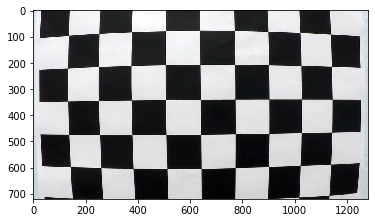

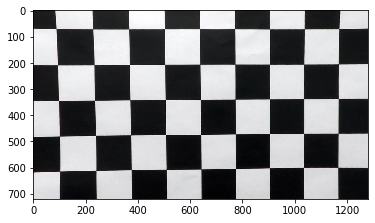

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners 
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
#        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
#        cv2.imshow('img',img)
#        cv2.waitKey(100)


ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# print("mtx: " ,mtx)
# print("dist: " ,dist)

# Read in an image
img = cv2.imread('camera_cal/calibration1.jpg')
print(img.shape)
plt.imshow(img)
plt.show()
plt.savefig("distorted.jpg")
undistorted = cal_undistort(img, objpoints, imgpoints)
plt.imshow(undistorted)
plt.savefig("undistorted.jpg")


# cv2.imshow('img',undistorted)
# cv2.waitKey(1000)
# print("undistorted")
# cv2.destroyAllWindows()


In [ ]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    image_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    channel_s = image_hls[:,:,2]
    # 3) Return a binary image of threshold result
    binary = np.zeros_like(channel_s)
    binary[(channel_s > thresh[0]) & (channel_s <= thresh[1])] = 1
    binary_output = binary # placeholder line
    return binary_output

def corners_unwarp(undistorted_img):
    # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    #dst = np.float32([[0,0],[undistorted_img.shape[1]-100,100],[undistorted_img.shape[1]-100,undistorted_img.shape[0]-100],[100,undistorted_img.shape[0]-100]])

    print("img.shape[0]", undistorted_img.shape[0])
    print("img.shape[1]", undistorted_img.shape[1])
    src  =  np.float32([[525, undistorted_img.shape[0]//2 + 90], [undistorted_img.shape[1] - 525, undistorted_img.shape[0]//2 + 90], [undistorted_img.shape[1], undistorted_img.shape[0]], [0, undistorted_img.shape[0]]])
    dst  =  np.float32([[0, 0],                                  [undistorted_img.shape[1], 0],                                      [undistorted_img.shape[1]-280, undistorted_img.shape[0]], [280, undistorted_img.shape[0]]])
    
    # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    print("M: ", M)
    # e) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(undistorted_img, M, (undistorted_img.shape[1], undistorted_img.shape[0]), flags=cv2.INTER_LINEAR)
    
    return warped, M

In [ ]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

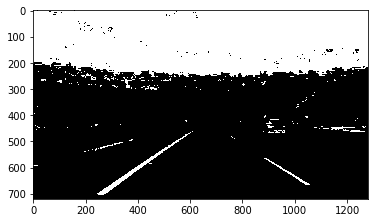

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]


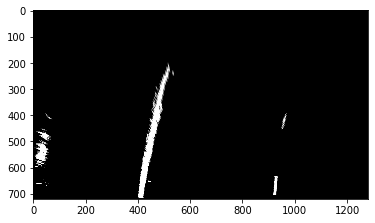

In fit_polynomial()
nonzero:  (array([199, 199, 199, ..., 715, 715, 719], dtype=int64), array([511, 512, 513, ..., 418, 419, 795], dtype=int64))
nonzerox:  [511 512 513 ... 418 419 795]
nonzeroy:  [199 199 199 ... 715 715 719]
(720, 1280)


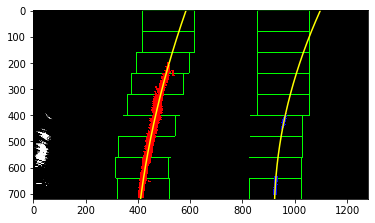

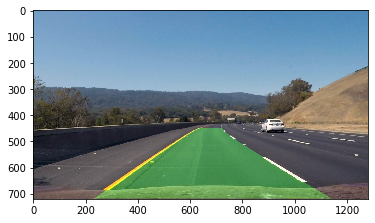

In [ ]:
img = mpimg.imread("./test_images/test3.jpg")

undistorted_img = cal_undistort(img, objpoints, imgpoints)

hls_binary = hls_select(undistorted_img, thresh=(100, 255))
hls_binary = hls_binary*255

plt.imshow(hls_binary, cmap='gray')
#plt.savefig("hls.jpg")
plt.show()

top_down, perspective_M = corners_unwarp(hls_binary)
plt.imshow(top_down, cmap='gray')
#plt.savefig("top_down.jpg")
plt.show()


[out_img,  left_fit, right_fit, left_fitx, right_fitx, ploty, lefty] = fit_polynomial(top_down)
plt.imshow(out_img, cmap='gray')
#plt.savefig("sliding_window.jpg")
plt.show()

result = draw_lines( top_down, img, left_fitx, right_fitx, ploty, np.linalg.inv(perspective_M) )
plt.imshow(result, cmap='gray')
plt.savefig("projected_back.jpg")
plt.show()



# image_gaussian = gaussian_blur(hls_binary, 5)

# # detect edges
# low_threshold = 150
# high_threshold = 200

# image_canny = canny(image_gaussian, low_threshold, high_threshold)
# plt.imshow(image_canny, cmap='gray')

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
In fit_polynomial()
nonzero:  (array([  0,   0,   0, ..., 716, 716, 716], dtype=int64), array([  1,   2,   3, ..., 404, 405, 406], dtype=int64))
nonzerox:  [  1   2   3 ... 404 405 406]
nonzeroy:  [  0   0   0 ... 716 716 716]
(720, 1280)
left_fit, right_fit:  [-5.00901255e-05  5.31104884e-02  3.84574980e+02] [1.19217907e-05 4.41091831e-03 8.91826260e+02]
max(nonzero[0]:  716
max(nonzero[1]:  909
len(leftx):  33241
len(rightx):  1760


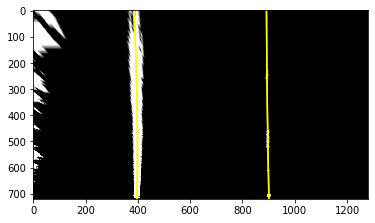

left_curverad, right_curverad:  3278.6531073639785 13775.495060306088
distance[m]:  2.6655541642478497


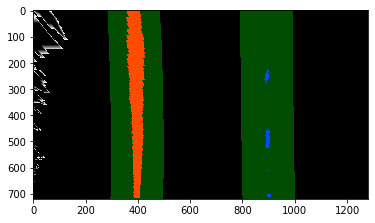

In [ ]:
#####################################################
## Images 
####################################################
#img = cv2.imread('test_images/straight_lines1.jpg')
img = cv2.imread('test_images/straight_lines1.jpg')
undistorted_img = cal_undistort(img, objpoints, imgpoints)
cv2.imshow('img_orig',undistorted_img)
cv2.waitKey(1000)

#rgb = img[...,::-1].copy()
hls_binary = hls_select(undistorted_img, thresh=(70, 255))
hls_binary = hls_binary*255
cv2.imshow('img_binary', hls_binary)
cv2.waitKey(1000)

top_down, perspective_M = corners_unwarp(hls_binary)
cv2.imshow('img_unwarped',top_down)
cv2.waitKey(1000)
plt.imshow(top_down, cmap='gray')
plt.savefig("top_down.jpg")

[out_img,  left_fit, right_fit, left_fitx, right_fitx, ploty, lefty] = fit_polynomial(top_down)
cv2.imshow("window", out_img)


result = draw_lines( top_down, img, left_fitx, right_fitx, ploty, np.linalg.inv(perspective_M) )
cv2.imshow("plot lines onto image", result)


print("left_fit, right_fit: ", left_fit, right_fit)
[result, left_fitx, right_fitx, ploty] = search_around_poly(top_down, left_fit, right_fit)
# View your output
plt.imshow(result)

# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(left_fitx, right_fitx, ploty)
print("left_curverad, right_curverad: ", left_curverad, right_curverad)

# print("left_fitx: ", left_fitx)
# print("ploty: ", ploty)

distance = (right_fitx[-1] - left_fitx[-1])*xm_per_pix
print("distance[m]: ", distance)

In [ ]:
#####################################################
## Video 
####################################################

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

initialized = False
initialized_filter = False
left_fit, right_fit, left_fitx, right_fitx, ploty, distance = None, None, None, None, None, None
prev_left_fitx = None
prev_right_fitx = None
prev_ploty = None
distance_avg = None

def process_image(image):
    global initialized
    global left_fit
    global right_fit
    global left_fitx
    global right_fitx
    global ploty
    global prev_left_fitx
    global prev_right_fitx
    global prev_ploty
    global initialized_filter
    global distance_avg
    
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    img = image
    undistorted_img = cal_undistort(img, objpoints, imgpoints)

    #rgb = img[...,::-1].copy()
    #hls_binary = hls_select(undistorted_img, thresh=(110, 255))
    hls_binary = hls_select(undistorted_img, thresh=(100, 255))
    hls_binary = hls_binary*255
    
    plt.imshow(hls_binary, cmap='gray')
    plt.show()

    top_down, perspective_M = corners_unwarp(hls_binary)
    
    if initialized:
        [result, left_fitx, right_fitx, ploty] = search_around_poly(top_down, left_fit, right_fit)
        left_curverad, right_curverad = measure_curvature_real(left_fitx, right_fitx, ploty)
        print("initialized, left_curverad, right_curverad: ", left_curverad, right_curverad)
        
        factor = 2.5
        if left_curverad * factor < right_curverad:
            print("left_curverad * factor < right_curvard")
            initialized = False 
        
        if right_curverad * factor < left_curverad:
            print("right_curverad * factor < left_curvard")
            initialized = False
        

    if not initialized:
        [out_img,  left_fit, right_fit, left_fitx, right_fitx, ploty, lefty] = fit_polynomial(top_down)
        result = out_img
        initialized = True
    
    if not initialized_filter:
        prev_left_fitx = left_fitx 
        prev_right_fitx = right_fitx
        prev_ploty = ploty
        distance1 = (right_fitx[0] - left_fitx[0])
        distance2 = (right_fitx[-1] - left_fitx[-1])
        distance_avg = (distance1 + distance2)//2
        initialized_filter = True

    plt.imshow(result)
    plt.show()
        
    distance1 = (right_fitx[0] - left_fitx[0])*xm_per_pix
    distance2 = (right_fitx[-1] - left_fitx[-1])*xm_per_pix
    distance_avg = (distance1 + distance2 + distance_avg)//3
    print("distance[m]: ", distance1, " ", distance2)
    
    
    # Calculate the radius of curvature in meters for both lane lines
    left_curverad, right_curverad = measure_curvature_real(left_fitx, right_fitx, ploty)
    print("left_curverad, right_curverad: ", left_curverad, right_curverad)

    if np.abs(distance1 - distance2) > 0.6:
        print("Using previous")
        result = draw_lines( top_down, img, prev_left_fitx, prev_right_fitx, prev_ploty, np.linalg.inv(perspective_M) )
        initialized = False
    else:
        prev_left_fitx = (left_fitx + prev_left_fitx)//2
        prev_right_fitx = (right_fitx + prev_right_fitx)//2
        prev_ploty = (ploty + prev_ploty)//2
        
        # Filter 
        result = draw_lines( top_down, img, (left_fitx + prev_left_fitx)//2, (right_fitx + prev_right_fitx)//2, (ploty+prev_ploty)//2, np.linalg.inv(perspective_M) )
    return result

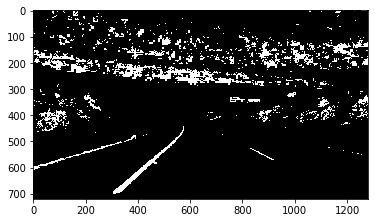

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
In fit_polynomial()
nonzero:  (array([  0,   0,   0, ..., 714, 714, 714], dtype=int64), array([257, 258, 259, ..., 442, 443, 444], dtype=int64))
nonzerox:  [257 258 259 ... 442 443 444]
nonzeroy:  [  0   0   0 ... 714 714 714]
(720, 1280)


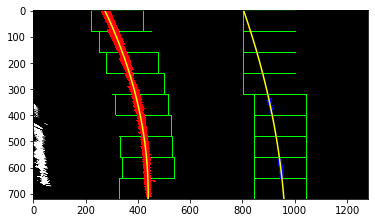

distance[m]:  2.804107911822093   2.7434524191681544
left_curverad, right_curverad:  485.9795265518846 886.1281322258571
Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4



t:   0%|                                             | 0/1260 [00:00<?, ?it/s, now=None]

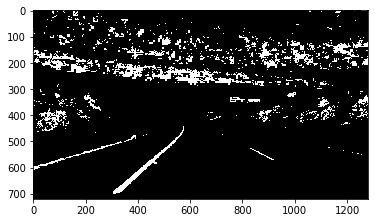

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  959
len(leftx):  23555
len(rightx):  2109


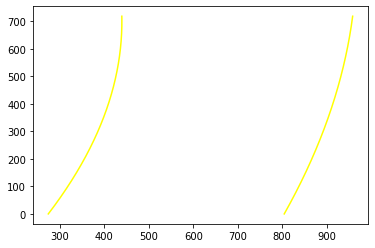

initialized, left_curverad, right_curverad:  485.97952655187515 886.1281322253648


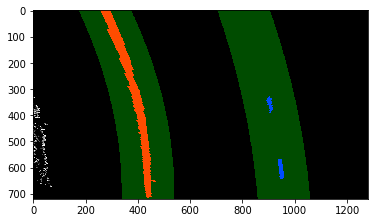

distance[m]:  2.8041079118220127   2.743452419168076
left_curverad, right_curverad:  485.97952655187515 886.1281322253648


t:   0%|                                     | 2/1260 [00:01<15:58,  1.31it/s, now=None]

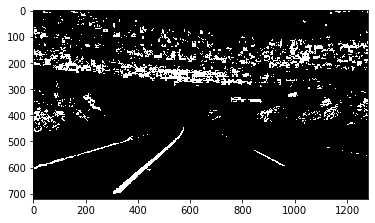

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  960
len(leftx):  23709
len(rightx):  2154


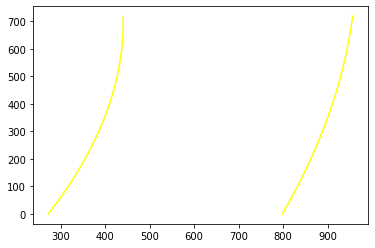

initialized, left_curverad, right_curverad:  477.4275153039281 850.9692565698274


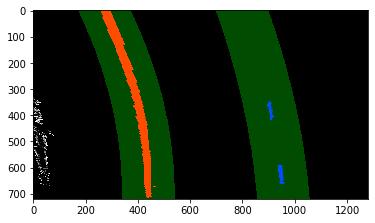

distance[m]:  2.78162942619838   2.7275725936440844
left_curverad, right_curverad:  477.4275153039281 850.9692565698274


t:   0%|                                     | 3/1260 [00:03<24:10,  1.15s/it, now=None]

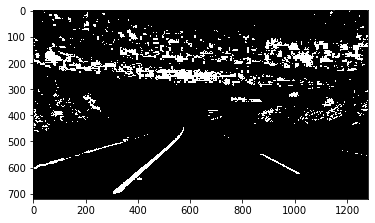

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  961
len(leftx):  24282
len(rightx):  2176


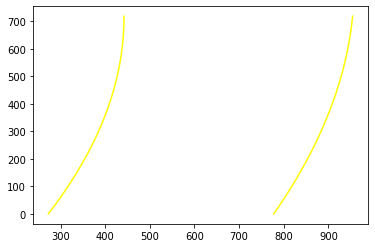

initialized, left_curverad, right_curverad:  494.3396836350067 641.1929956751557


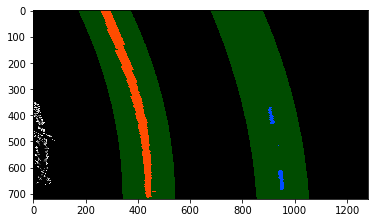

distance[m]:  2.6694343614286042   2.7081142660956163
left_curverad, right_curverad:  494.3396836350067 641.1929956751557


t:   0%|                                     | 4/1260 [00:05<28:21,  1.36s/it, now=None]

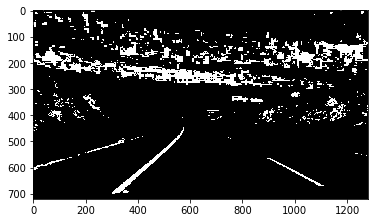

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  962
len(leftx):  24023
len(rightx):  2167


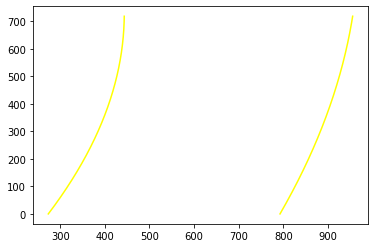

initialized, left_curverad, right_curverad:  511.8695101586539 917.8925067822769


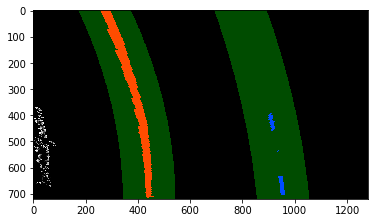

distance[m]:  2.7453811718475913   2.706255834402108
left_curverad, right_curverad:  511.8695101586539 917.8925067822769


t:   0%|▏                                    | 5/1260 [00:06<29:46,  1.42s/it, now=None]

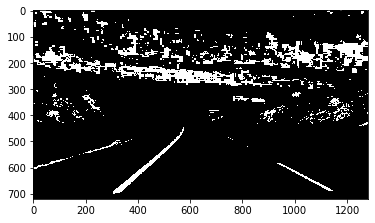

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  962
len(leftx):  24129
len(rightx):  1935


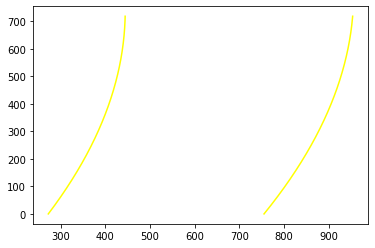

initialized, left_curverad, right_curverad:  521.1628906202869 527.0762164051004


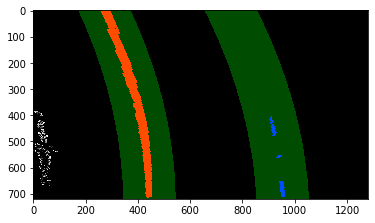

distance[m]:  2.5534947300577953   2.692808398356683
left_curverad, right_curverad:  521.1628906202869 527.0762164051004


t:   0%|▏                                    | 6/1260 [00:08<31:55,  1.53s/it, now=None]

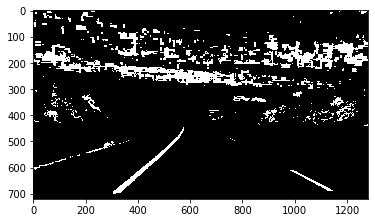

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  961
len(leftx):  22600
len(rightx):  1562


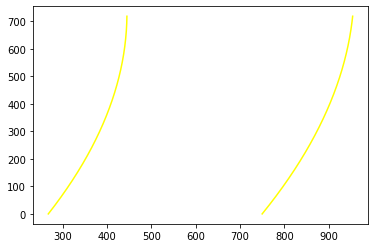

initialized, left_curverad, right_curverad:  493.96051711152074 539.3893838755604


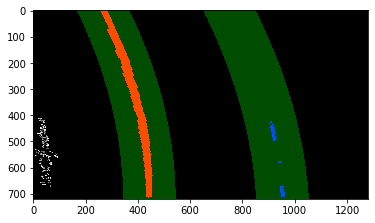

distance[m]:  2.547779009396349   2.689360718703473
left_curverad, right_curverad:  493.96051711152074 539.3893838755604


t:   1%|▏                                    | 7/1260 [00:10<33:57,  1.63s/it, now=None]

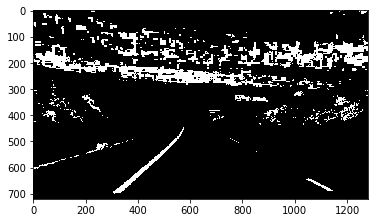

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  962
len(leftx):  22670
len(rightx):  1402
adding 537


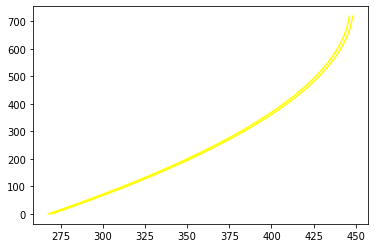

initialized, left_curverad, right_curverad:  522.4106938538094 522.4106938538076


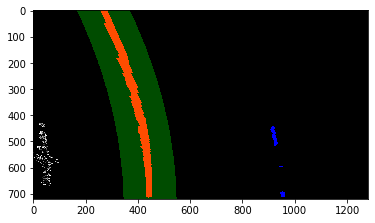

distance[m]:  0.010571428571428572   0.010571428571428572
left_curverad, right_curverad:  522.4106938538094 522.4106938538076


t:   1%|▏                                    | 8/1260 [00:12<37:01,  1.77s/it, now=None]

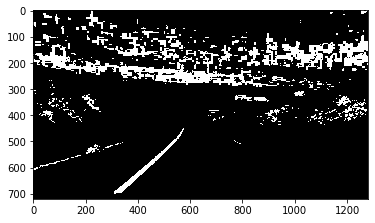

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  956
len(leftx):  22466
len(rightx):  1056
adding 537


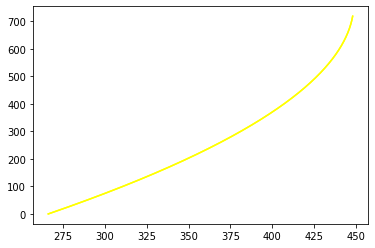

initialized, left_curverad, right_curverad:  528.5880763786391 528.5880763786391


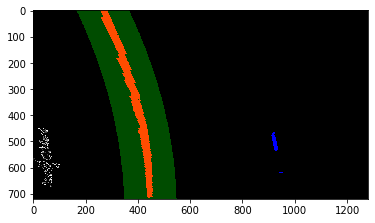

distance[m]:  0.0   0.0
left_curverad, right_curverad:  528.5880763786391 528.5880763786391


t:   1%|▎                                    | 9/1260 [00:14<36:57,  1.77s/it, now=None]

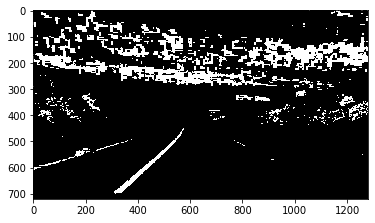

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  958
len(leftx):  23508
len(rightx):  1153
adding 537


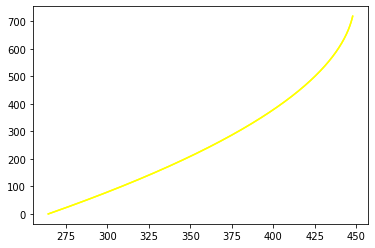

initialized, left_curverad, right_curverad:  544.7964594150793 544.7964594150793


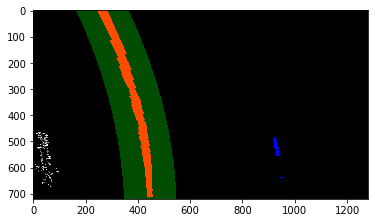

distance[m]:  0.0   0.0
left_curverad, right_curverad:  544.7964594150793 544.7964594150793


t:   1%|▎                                   | 10/1260 [00:16<36:11,  1.74s/it, now=None]

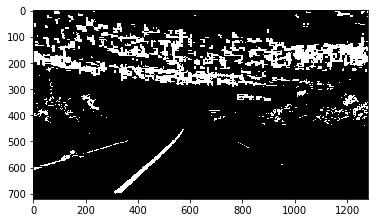

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  961
len(leftx):  23370
len(rightx):  1173
adding 537


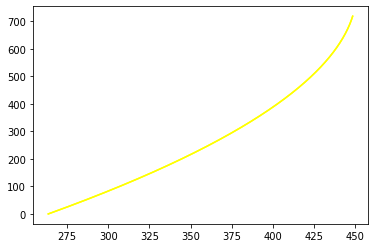

initialized, left_curverad, right_curverad:  577.6222848888448 577.6222848888448


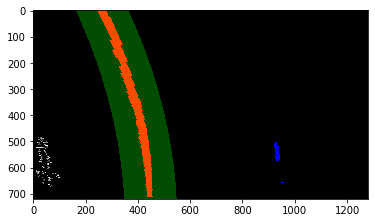

distance[m]:  0.0   0.0
left_curverad, right_curverad:  577.6222848888448 577.6222848888448


t:   1%|▎                                   | 11/1260 [00:17<34:42,  1.67s/it, now=None]

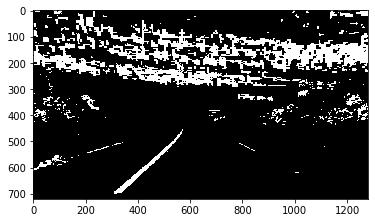

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  962
len(leftx):  22262
len(rightx):  1288
adding 537


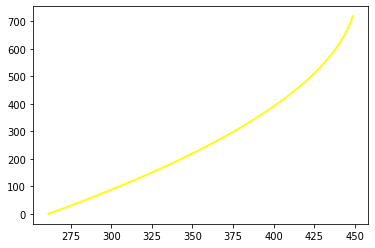

initialized, left_curverad, right_curverad:  571.3356469886658 571.3356469886658


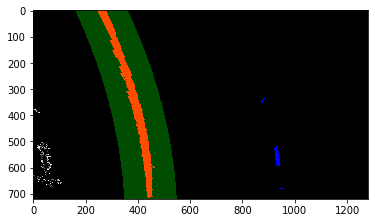

distance[m]:  0.0   0.0
left_curverad, right_curverad:  571.3356469886658 571.3356469886658


t:   1%|▎                                   | 12/1260 [00:19<33:39,  1.62s/it, now=None]

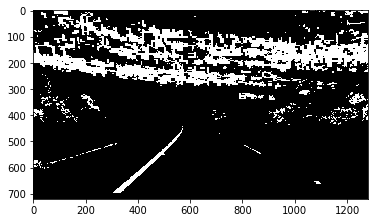

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  713
max(nonzero[1]:  967
len(leftx):  21895
len(rightx):  1751


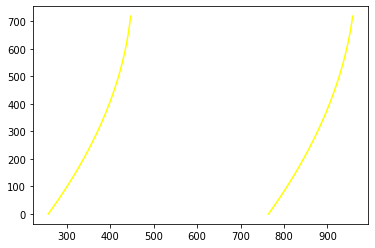

initialized, left_curverad, right_curverad:  601.0978535181923 644.9368147847404


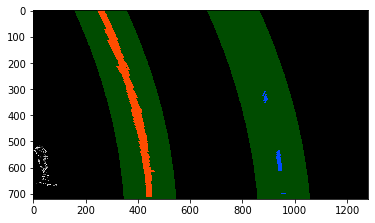

distance[m]:  2.6805459598874988   2.7023342719038017
left_curverad, right_curverad:  601.0978535181923 644.9368147847404


t:   1%|▎                                   | 13/1260 [00:20<33:06,  1.59s/it, now=None]

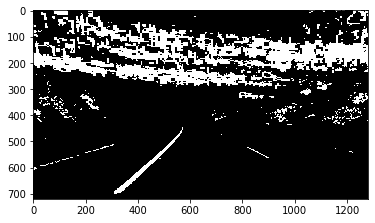

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  955
len(leftx):  22298
len(rightx):  1599


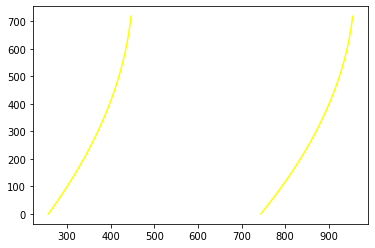

initialized, left_curverad, right_curverad:  599.503624825301 532.5875552887192


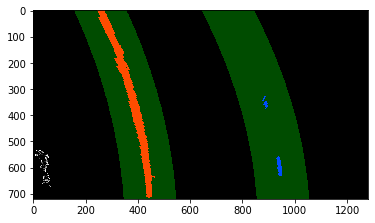

distance[m]:  2.576401321721642   2.6873332305433446
left_curverad, right_curverad:  599.503624825301 532.5875552887192


t:   1%|▍                                   | 14/1260 [00:22<32:25,  1.56s/it, now=None]

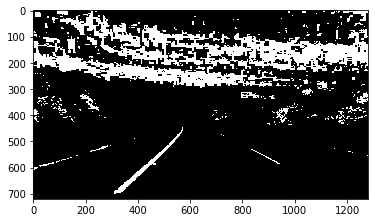

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  956
len(leftx):  22181
len(rightx):  1770


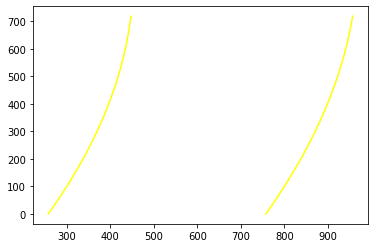

initialized, left_curverad, right_curverad:  630.4268378717342 687.1482864973977


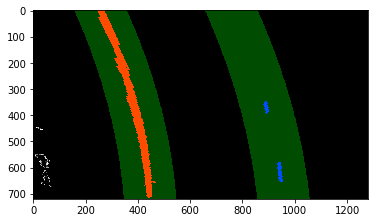

distance[m]:  2.641615576685999   2.6930712891902155
left_curverad, right_curverad:  630.4268378717342 687.1482864973977


t:   1%|▍                                   | 15/1260 [00:23<31:44,  1.53s/it, now=None]

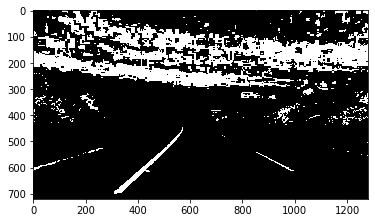

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  955
len(leftx):  21913
len(rightx):  1983


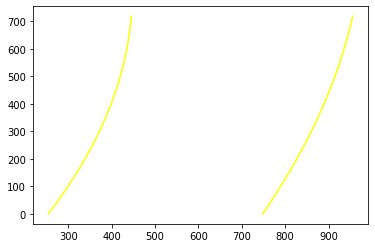

initialized, left_curverad, right_curverad:  543.410077074555 806.0624266751794


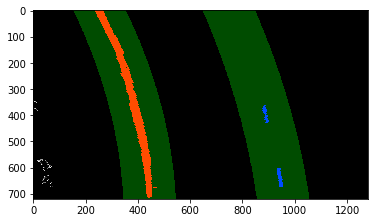

distance[m]:  2.610494239592713   2.698226579432132
left_curverad, right_curverad:  543.410077074555 806.0624266751794


t:   1%|▍                                   | 16/1260 [00:25<31:50,  1.54s/it, now=None]

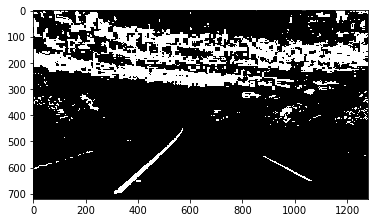

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  955
len(leftx):  20789
len(rightx):  1826


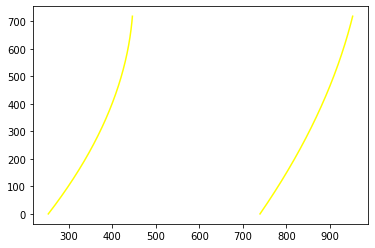

initialized, left_curverad, right_curverad:  539.4342637778013 847.7377127995087


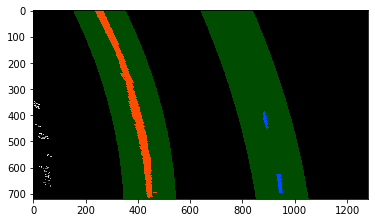

distance[m]:  2.5723666224643686   2.676389346955957
left_curverad, right_curverad:  539.4342637778013 847.7377127995087


t:   1%|▍                                   | 17/1260 [00:26<31:56,  1.54s/it, now=None]

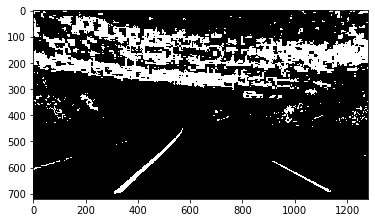

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  956
len(leftx):  21226
len(rightx):  1800


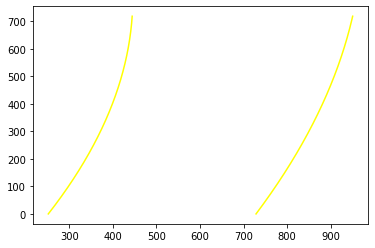

initialized, left_curverad, right_curverad:  524.4955422348127 718.8255722018641


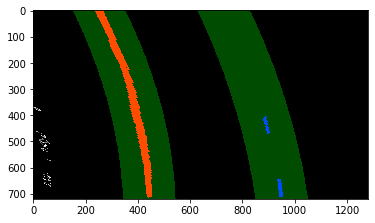

distance[m]:  2.520121822933355   2.6746158241975135
left_curverad, right_curverad:  524.4955422348127 718.8255722018641


t:   1%|▌                                   | 18/1260 [00:28<31:32,  1.52s/it, now=None]

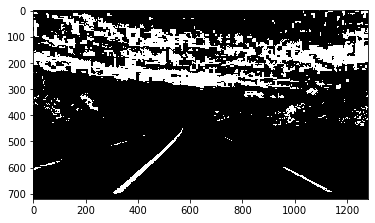

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  955
len(leftx):  20576
len(rightx):  1656


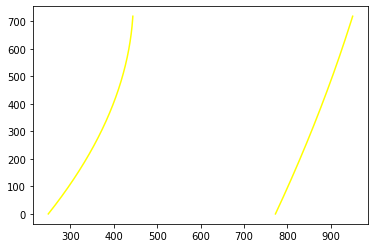

initialized, left_curverad, right_curverad:  508.4909254380354 2414.549392372513
left_curverad * factor < right_curvard
In fit_polynomial()
nonzero:  (array([  0,   0,   0, ..., 714, 714, 714], dtype=int64), array([234, 235, 236, ..., 444, 445, 446], dtype=int64))
nonzerox:  [234 235 236 ... 444 445 446]
nonzeroy:  [  0   0   0 ... 714 714 714]
(720, 1280)


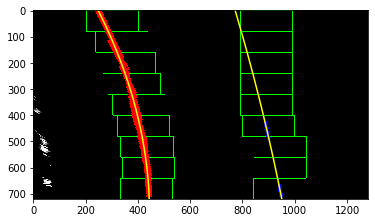

distance[m]:  2.766549575970877   2.6773230151762926
left_curverad, right_curverad:  508.4909254380272 2414.5493923720674


t:   2%|▌                                   | 19/1260 [00:29<31:23,  1.52s/it, now=None]

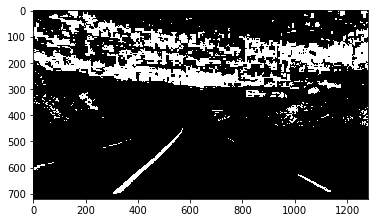

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  957
len(leftx):  21148
len(rightx):  1379
adding 537


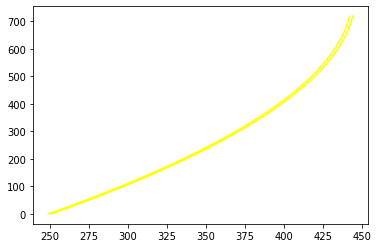

initialized, left_curverad, right_curverad:  522.4167704468724 522.4167704468666


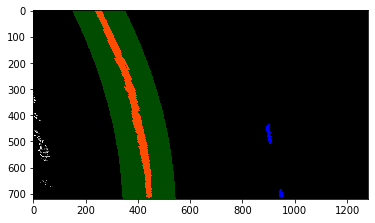

distance[m]:  0.010571428571428572   0.010571428571428572
left_curverad, right_curverad:  522.4167704468724 522.4167704468666


t:   2%|▌                                   | 20/1260 [00:31<31:30,  1.52s/it, now=None]

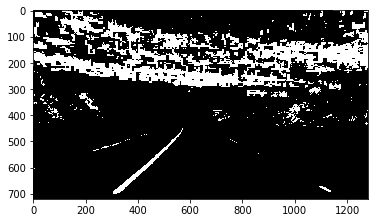

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  955
len(leftx):  20748
len(rightx):  1181
adding 537


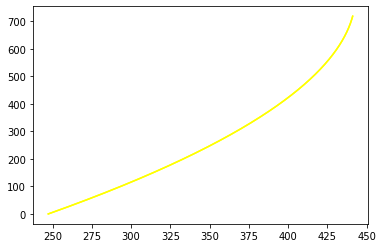

initialized, left_curverad, right_curverad:  531.9044652032107 531.9044652032107


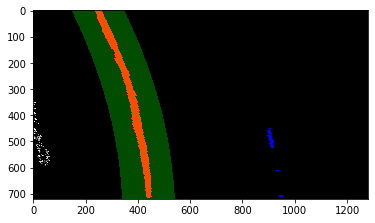

distance[m]:  0.0   0.0
left_curverad, right_curverad:  531.9044652032107 531.9044652032107


t:   2%|▌                                   | 21/1260 [00:32<31:33,  1.53s/it, now=None]

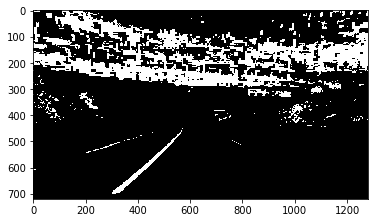

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  946
len(leftx):  20586
len(rightx):  1062
adding 537


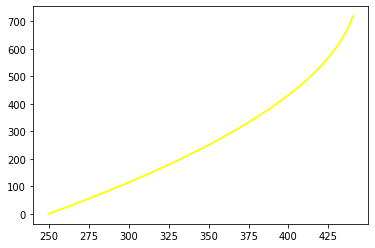

initialized, left_curverad, right_curverad:  569.4630821333469 569.4630821333469


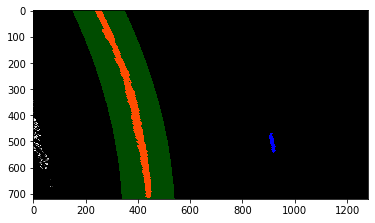

distance[m]:  0.0   0.0
left_curverad, right_curverad:  569.4630821333469 569.4630821333469


t:   2%|▋                                   | 22/1260 [00:34<31:16,  1.52s/it, now=None]

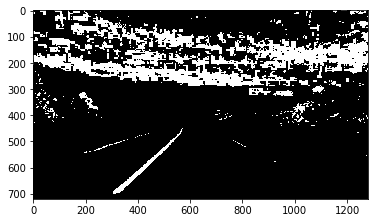

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  952
len(leftx):  21628
len(rightx):  1203
adding 537


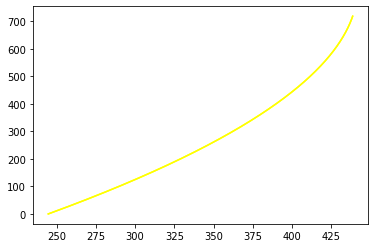

initialized, left_curverad, right_curverad:  564.3936261829557 564.3936261829557


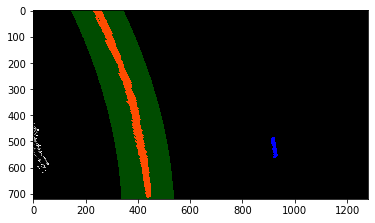

distance[m]:  0.0   0.0
left_curverad, right_curverad:  564.3936261829557 564.3936261829557


t:   2%|▋                                   | 23/1260 [00:35<30:59,  1.50s/it, now=None]

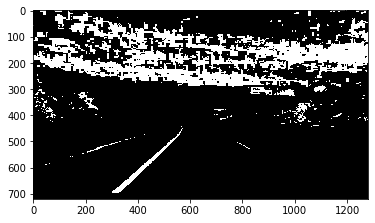

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  954
len(leftx):  21674
len(rightx):  1176
adding 537


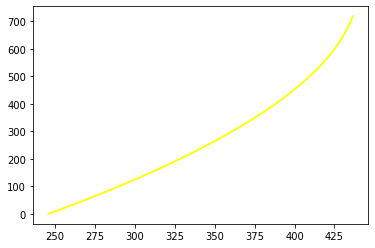

initialized, left_curverad, right_curverad:  580.3593177835186 580.3593177835186


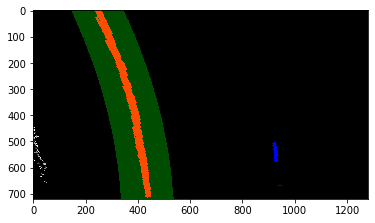

distance[m]:  0.0   0.0
left_curverad, right_curverad:  580.3593177835186 580.3593177835186


t:   2%|▋                                   | 24/1260 [00:37<32:03,  1.56s/it, now=None]

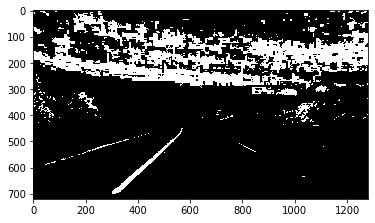

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  956
len(leftx):  22091
len(rightx):  1215
adding 537


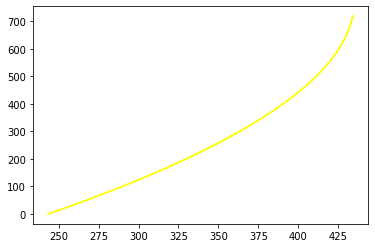

initialized, left_curverad, right_curverad:  512.9772832131025 512.9772832131025


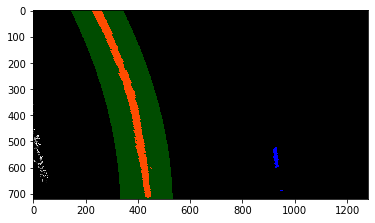

distance[m]:  0.0   0.0
left_curverad, right_curverad:  512.9772832131025 512.9772832131025


t:   2%|▋                                   | 25/1260 [00:39<35:08,  1.71s/it, now=None]

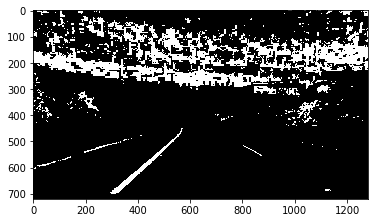

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  957
len(leftx):  21941
len(rightx):  1182
adding 537


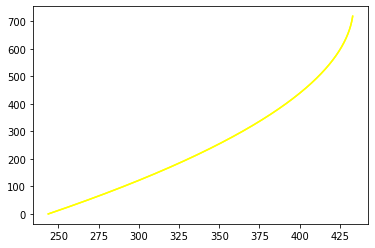

initialized, left_curverad, right_curverad:  495.4410171138026 495.4410171138026


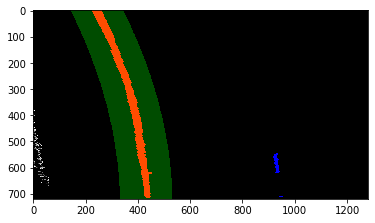

distance[m]:  0.0   0.0
left_curverad, right_curverad:  495.4410171138026 495.4410171138026


t:   2%|▋                                   | 26/1260 [00:41<35:22,  1.72s/it, now=None]

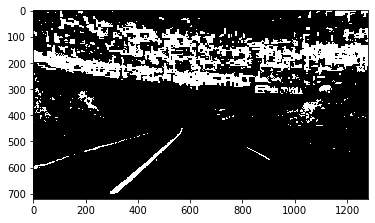

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  947
len(leftx):  21923
len(rightx):  1122
adding 537


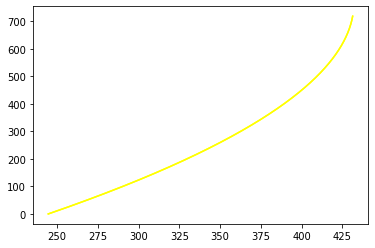

initialized, left_curverad, right_curverad:  515.9615035582849 515.9615035582849


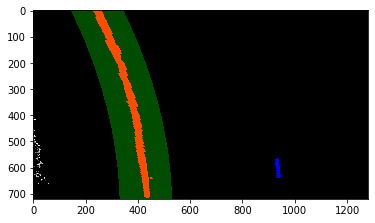

distance[m]:  0.0   0.0
left_curverad, right_curverad:  515.9615035582849 515.9615035582849


t:   2%|▊                                   | 27/1260 [00:42<35:14,  1.71s/it, now=None]

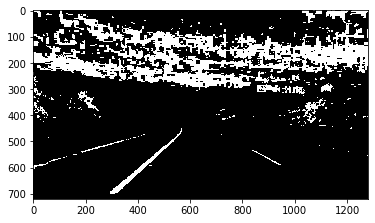

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  951
len(leftx):  21857
len(rightx):  1368
adding 537


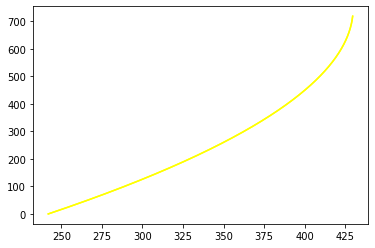

initialized, left_curverad, right_curverad:  488.4323771274522 488.4323771274522


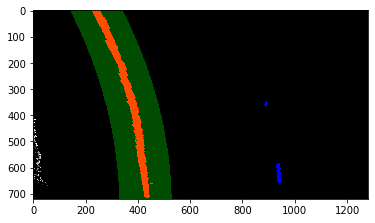

distance[m]:  0.0   0.0
left_curverad, right_curverad:  488.4323771274522 488.4323771274522


t:   2%|▊                                   | 28/1260 [00:44<35:53,  1.75s/it, now=None]

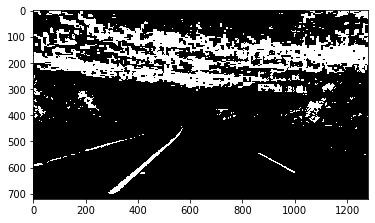

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  954
len(leftx):  22047
len(rightx):  1158
adding 537


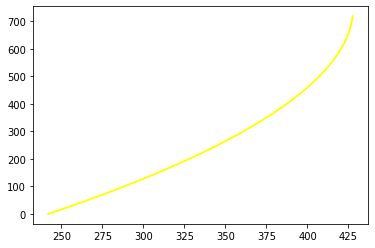

initialized, left_curverad, right_curverad:  498.20317864473316 498.20317864473316


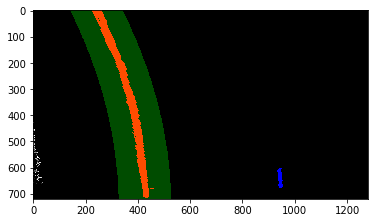

distance[m]:  0.0   0.0
left_curverad, right_curverad:  498.20317864473316 498.20317864473316


t:   2%|▊                                   | 29/1260 [00:46<36:47,  1.79s/it, now=None]

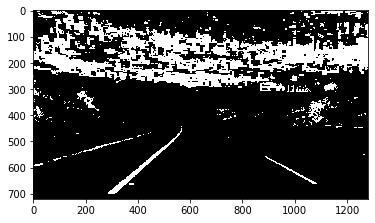

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  955
len(leftx):  22486
len(rightx):  1795


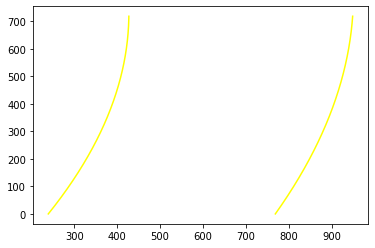

initialized, left_curverad, right_curverad:  466.180679607367 576.7676856568122


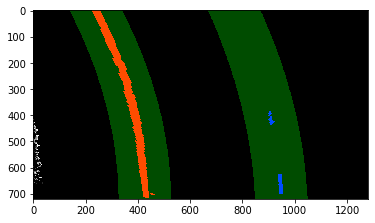

distance[m]:  2.7955034086450152   2.75569865111566
left_curverad, right_curverad:  466.180679607367 576.7676856568122


t:   2%|▊                                   | 30/1260 [00:48<36:14,  1.77s/it, now=None]

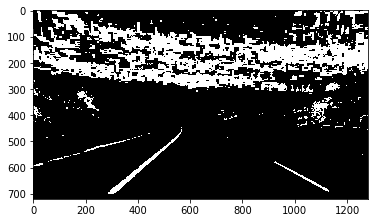

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  955
len(leftx):  21516
len(rightx):  1541


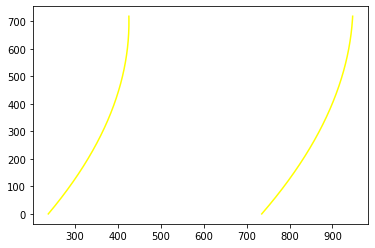

initialized, left_curverad, right_curverad:  426.4408408534423 453.5509391307652


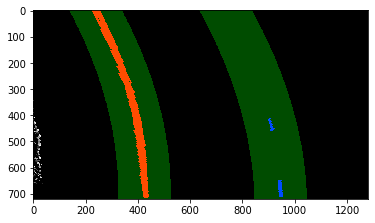

distance[m]:  2.626653216043297   2.7539771707038936
left_curverad, right_curverad:  426.4408408534423 453.5509391307652


t:   2%|▉                                   | 31/1260 [00:50<36:55,  1.80s/it, now=None]

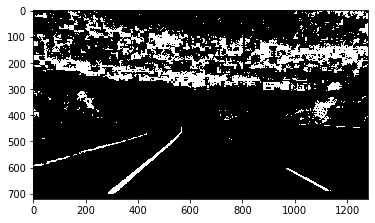

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  955
len(leftx):  20554
len(rightx):  1689


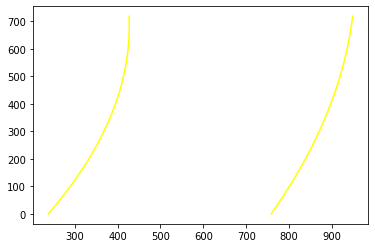

initialized, left_curverad, right_curverad:  404.75588268175386 632.5301623229219


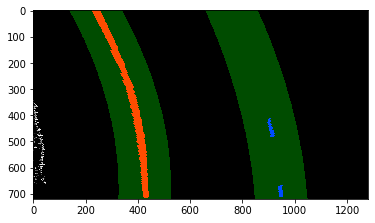

distance[m]:  2.7487938911324887   2.7575585868264407
left_curverad, right_curverad:  404.75588268175386 632.5301623229219


t:   3%|▉                                   | 32/1260 [00:52<40:24,  1.97s/it, now=None]

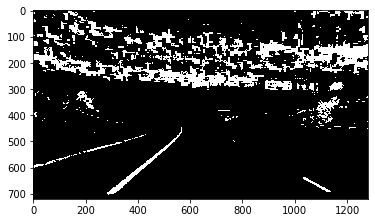

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  715
max(nonzero[1]:  953
len(leftx):  20284
len(rightx):  1313
adding 537


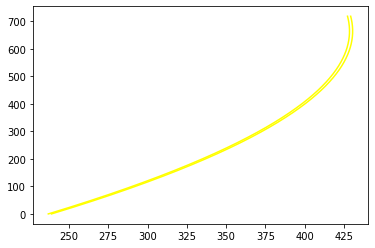

initialized, left_curverad, right_curverad:  378.86024946474043 378.8602494647417


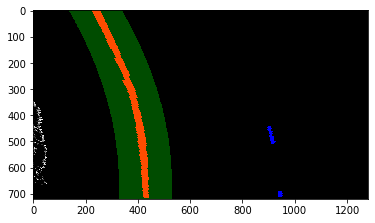

distance[m]:  0.010571428571428572   0.010571428571428572
left_curverad, right_curverad:  378.86024946474043 378.8602494647417


t:   3%|▉                                   | 33/1260 [00:55<47:57,  2.35s/it, now=None]

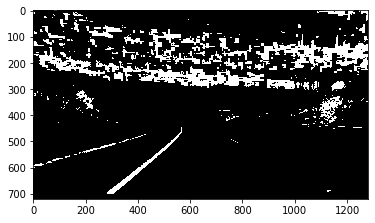

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  955
len(leftx):  20767
len(rightx):  1029
adding 537


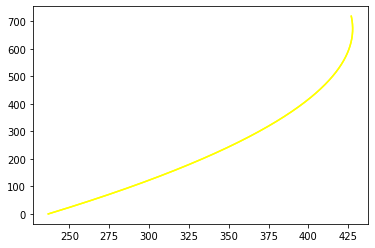

initialized, left_curverad, right_curverad:  390.05325986431166 390.05325986431166


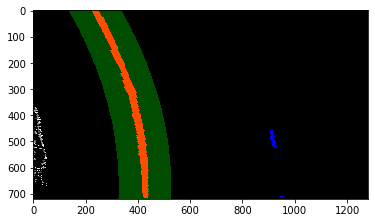

distance[m]:  0.0   0.0
left_curverad, right_curverad:  390.05325986431166 390.05325986431166


t:   3%|▉                                   | 34/1260 [00:58<47:50,  2.34s/it, now=None]

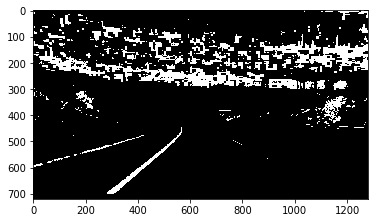

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  950
len(leftx):  19891
len(rightx):  973
adding 537


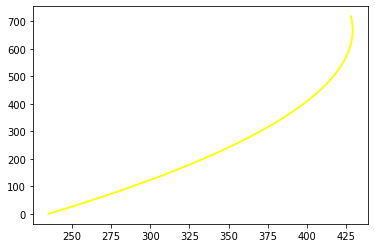

initialized, left_curverad, right_curverad:  378.0380663485089 378.0380663485089


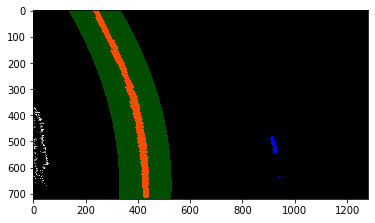

distance[m]:  0.0   0.0
left_curverad, right_curverad:  378.0380663485089 378.0380663485089


t:   3%|█                                   | 35/1260 [01:00<44:55,  2.20s/it, now=None]

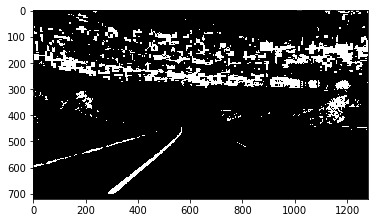

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  954
len(leftx):  19420
len(rightx):  972
adding 537


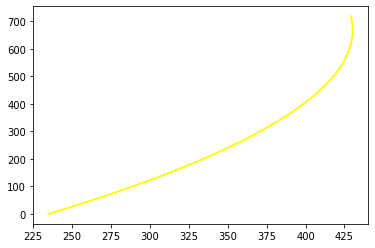

initialized, left_curverad, right_curverad:  375.915435047224 375.915435047224


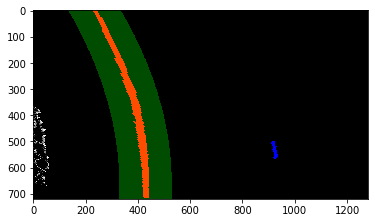

distance[m]:  0.0   0.0
left_curverad, right_curverad:  375.915435047224 375.915435047224


t:   3%|█                                   | 36/1260 [01:01<41:44,  2.05s/it, now=None]

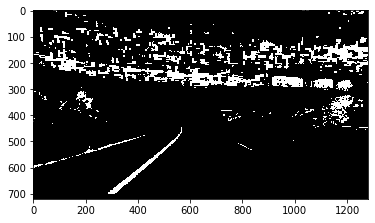

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  957
len(leftx):  19454
len(rightx):  1046
adding 537


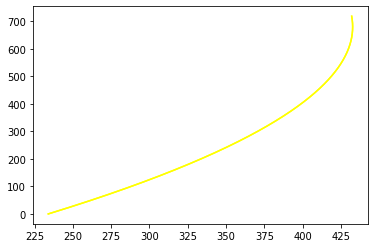

initialized, left_curverad, right_curverad:  382.6578498599971 382.6578498599971


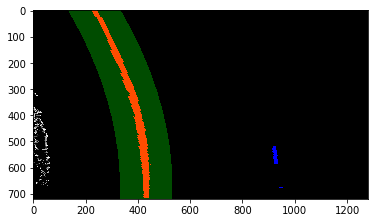

distance[m]:  0.0   0.0
left_curverad, right_curverad:  382.6578498599971 382.6578498599971


t:   3%|█                                   | 37/1260 [01:03<39:18,  1.93s/it, now=None]

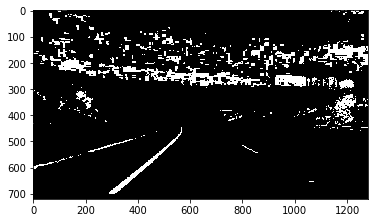

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  956
len(leftx):  19848
len(rightx):  1205
adding 537


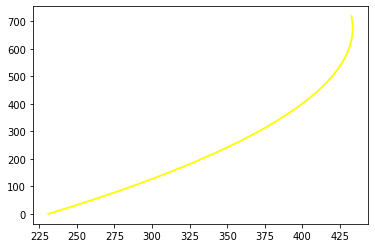

initialized, left_curverad, right_curverad:  370.49504638397025 370.49504638397025


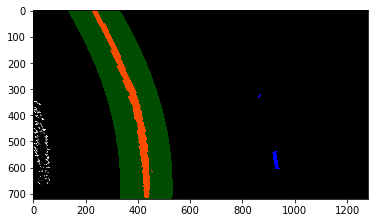

distance[m]:  0.0   0.0
left_curverad, right_curverad:  370.49504638397025 370.49504638397025


t:   3%|█                                   | 38/1260 [01:05<39:14,  1.93s/it, now=None]

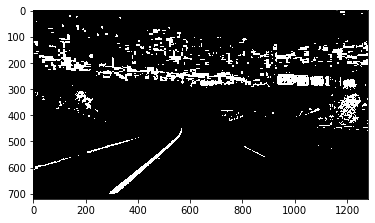

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  944
len(leftx):  21213
len(rightx):  1307
adding 537


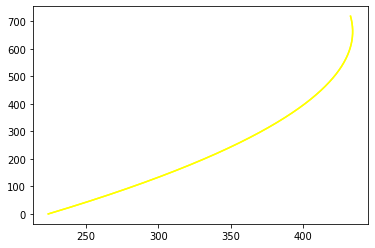

initialized, left_curverad, right_curverad:  343.5160325952937 343.5160325952937


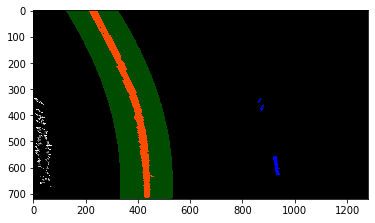

distance[m]:  0.0   0.0
left_curverad, right_curverad:  343.5160325952937 343.5160325952937


t:   3%|█                                   | 39/1260 [01:06<36:58,  1.82s/it, now=None]

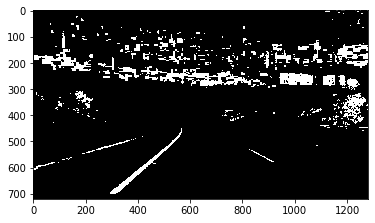

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  944
len(leftx):  20490
len(rightx):  1232
adding 537


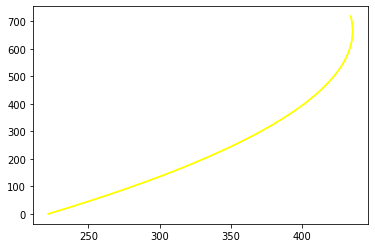

initialized, left_curverad, right_curverad:  340.2896898355635 340.2896898355635


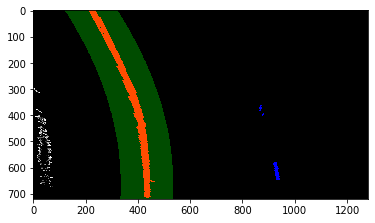

distance[m]:  0.0   0.0
left_curverad, right_curverad:  340.2896898355635 340.2896898355635


t:   3%|█▏                                  | 40/1260 [01:08<34:52,  1.71s/it, now=None]

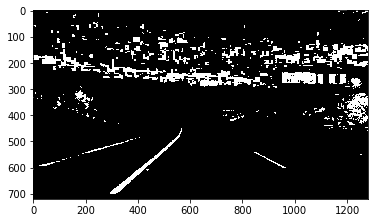

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  948
len(leftx):  20230
len(rightx):  1302
adding 537


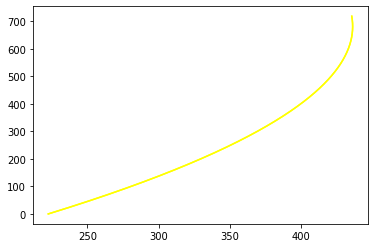

initialized, left_curverad, right_curverad:  357.77927798600274 357.77927798600274


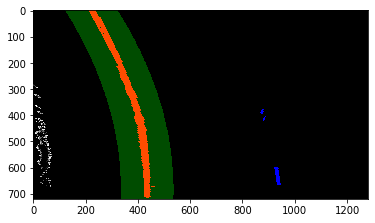

distance[m]:  0.0   0.0
left_curverad, right_curverad:  357.77927798600274 357.77927798600274


t:   3%|█▏                                  | 41/1260 [01:09<34:09,  1.68s/it, now=None]

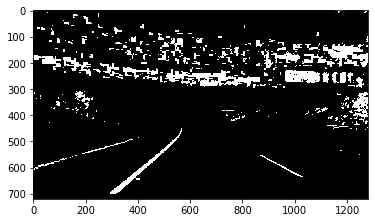

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  951
len(leftx):  19856
len(rightx):  1449
adding 537


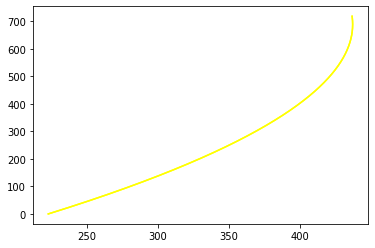

initialized, left_curverad, right_curverad:  364.8966836449797 364.8966836449797


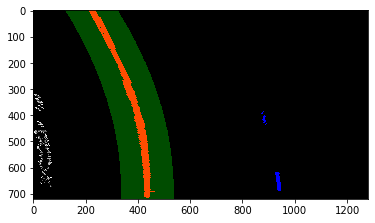

distance[m]:  0.0   0.0
left_curverad, right_curverad:  364.8966836449797 364.8966836449797


t:   3%|█▏                                  | 42/1260 [01:11<33:14,  1.64s/it, now=None]

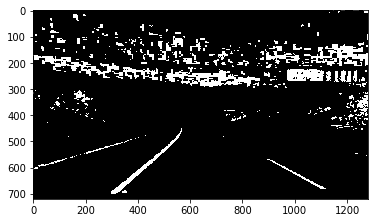

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  954
len(leftx):  20436
len(rightx):  1785


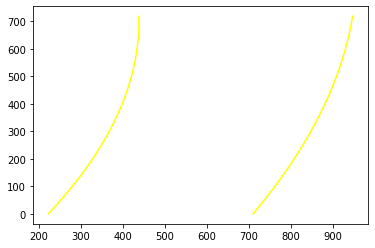

initialized, left_curverad, right_curverad:  375.38439404577724 535.2858078645185


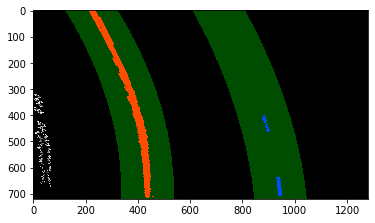

distance[m]:  2.571731807646006   2.6854464718091653
left_curverad, right_curverad:  375.38439404577724 535.2858078645185


t:   3%|█▏                                  | 43/1260 [01:13<32:36,  1.61s/it, now=None]

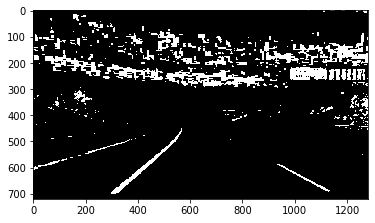

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  954
len(leftx):  20614
len(rightx):  1588


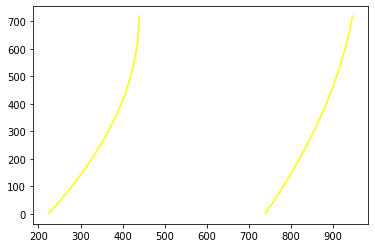

initialized, left_curverad, right_curverad:  392.6279886612645 711.3929110156743


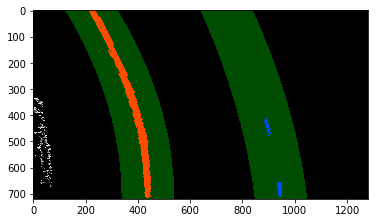

distance[m]:  2.725937298091013   2.6876987853540406
left_curverad, right_curverad:  392.6279886612645 711.3929110156743


t:   3%|█▎                                  | 44/1260 [01:14<32:08,  1.59s/it, now=None]

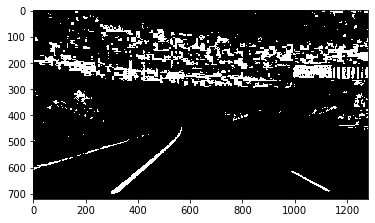

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  954
len(leftx):  21464
len(rightx):  1372
adding 537


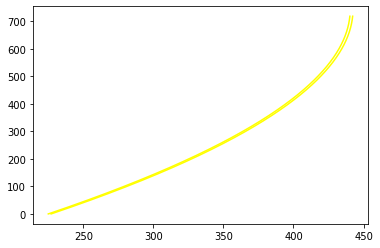

initialized, left_curverad, right_curverad:  422.0464433461902 422.04644334618814


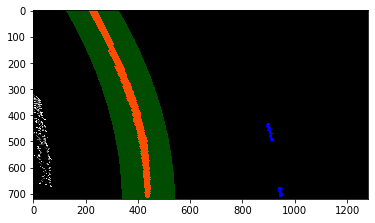

distance[m]:  0.010571428571428572   0.010571428571428572
left_curverad, right_curverad:  422.0464433461902 422.04644334618814


t:   4%|█▎                                  | 45/1260 [01:16<31:47,  1.57s/it, now=None]

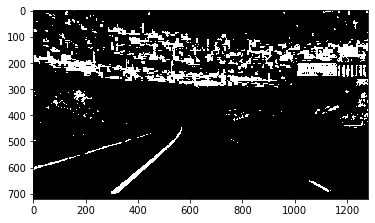

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  956
len(leftx):  20966
len(rightx):  1205
adding 537


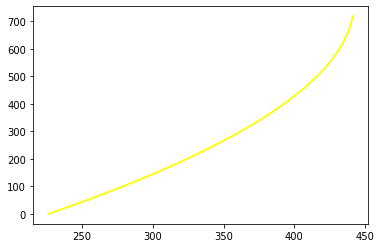

initialized, left_curverad, right_curverad:  446.924377460505 446.924377460505


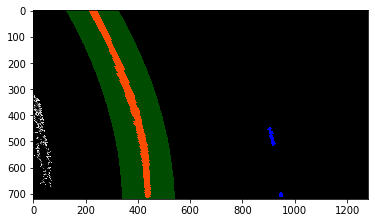

distance[m]:  0.0   0.0
left_curverad, right_curverad:  446.924377460505 446.924377460505


t:   4%|█▎                                  | 46/1260 [01:17<31:35,  1.56s/it, now=None]

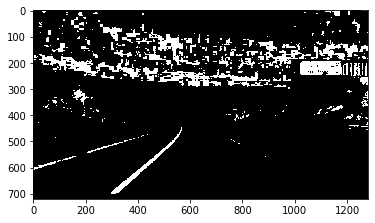

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  949
len(leftx):  21792
len(rightx):  1040
adding 537


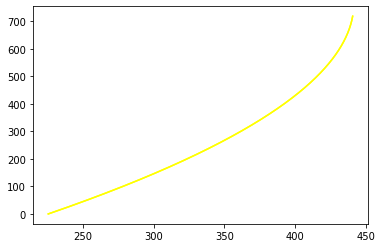

initialized, left_curverad, right_curverad:  446.16779847675815 446.16779847675815


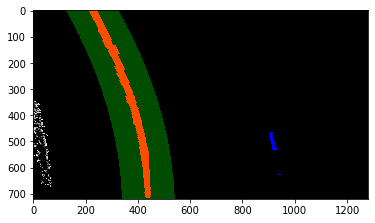

distance[m]:  0.0   0.0
left_curverad, right_curverad:  446.16779847675815 446.16779847675815


t:   4%|█▎                                  | 47/1260 [01:19<31:24,  1.55s/it, now=None]

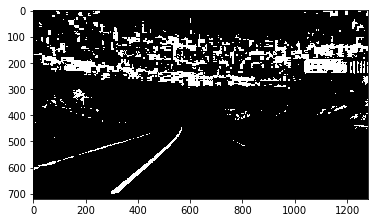

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  952
len(leftx):  21499
len(rightx):  1119
adding 537


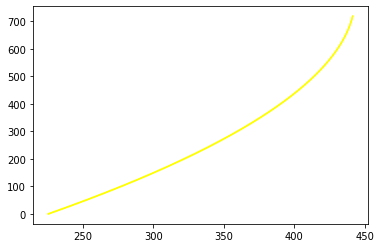

initialized, left_curverad, right_curverad:  469.84782805575173 469.84782805575173


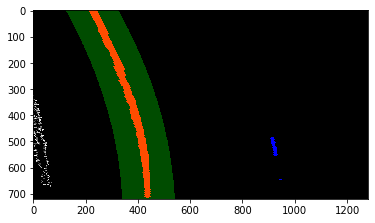

distance[m]:  0.0   0.0
left_curverad, right_curverad:  469.84782805575173 469.84782805575173


t:   4%|█▎                                  | 48/1260 [01:20<32:17,  1.60s/it, now=None]

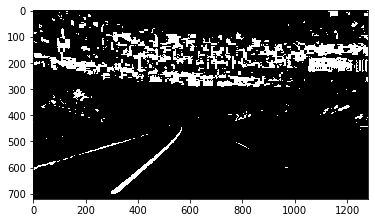

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  954
len(leftx):  21366
len(rightx):  1162
adding 537


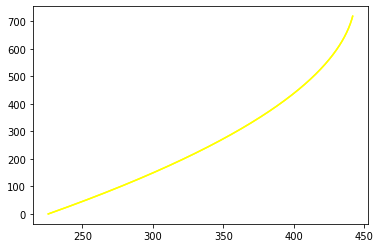

initialized, left_curverad, right_curverad:  475.33857026041943 475.33857026041943


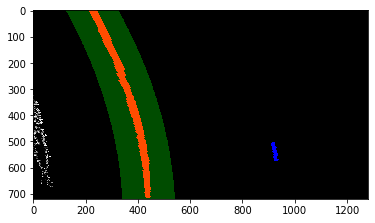

distance[m]:  0.0   0.0
left_curverad, right_curverad:  475.33857026041943 475.33857026041943


t:   4%|█▍                                  | 49/1260 [01:22<32:41,  1.62s/it, now=None]

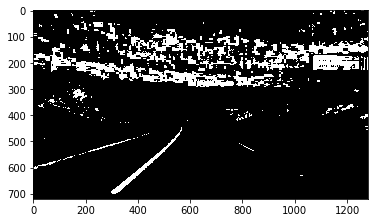

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  957
len(leftx):  22081
len(rightx):  1185
adding 537


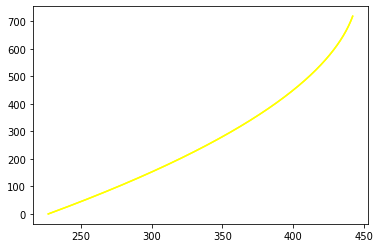

initialized, left_curverad, right_curverad:  518.4307949116269 518.4307949116269


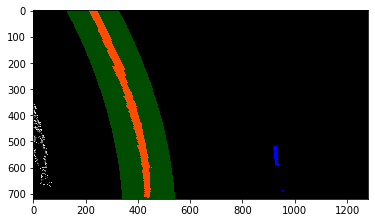

distance[m]:  0.0   0.0
left_curverad, right_curverad:  518.4307949116269 518.4307949116269


t:   4%|█▍                                  | 50/1260 [01:24<32:33,  1.61s/it, now=None]

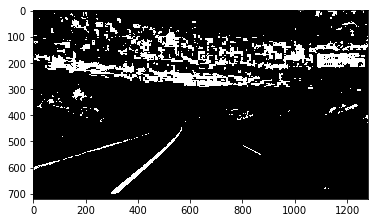

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  959
len(leftx):  21598
len(rightx):  1151
adding 537


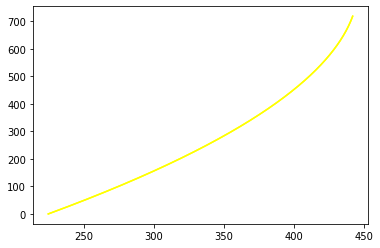

initialized, left_curverad, right_curverad:  513.28948086962 513.28948086962


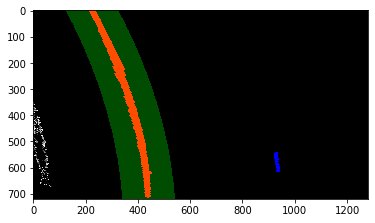

distance[m]:  0.0   0.0
left_curverad, right_curverad:  513.28948086962 513.28948086962


t:   4%|█▍                                  | 51/1260 [01:25<32:08,  1.60s/it, now=None]

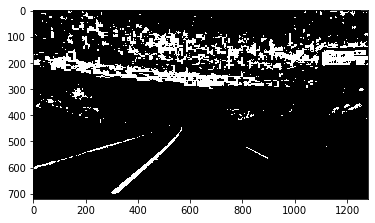

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  949
len(leftx):  21231
len(rightx):  1114
adding 537


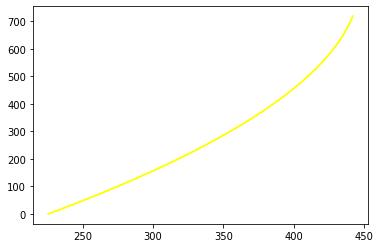

initialized, left_curverad, right_curverad:  528.9266433116999 528.9266433116999


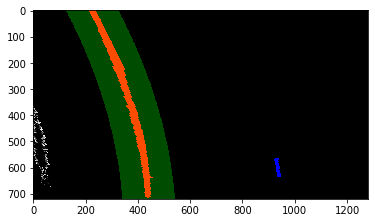

distance[m]:  0.0   0.0
left_curverad, right_curverad:  528.9266433116999 528.9266433116999


t:   4%|█▍                                  | 52/1260 [01:27<31:53,  1.58s/it, now=None]

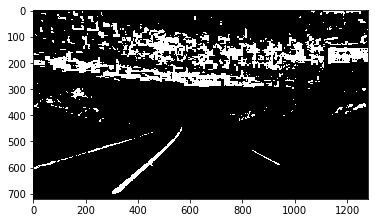

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  948
len(leftx):  21389
len(rightx):  1302
adding 537


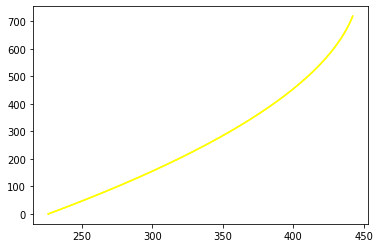

initialized, left_curverad, right_curverad:  529.7448815131834 529.7448815131834


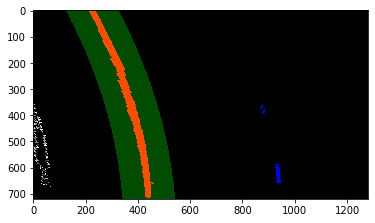

distance[m]:  0.0   0.0
left_curverad, right_curverad:  529.7448815131834 529.7448815131834


t:   4%|█▌                                  | 53/1260 [01:28<31:46,  1.58s/it, now=None]

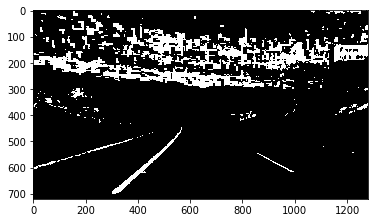

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  951
len(leftx):  21058
len(rightx):  1265
adding 537


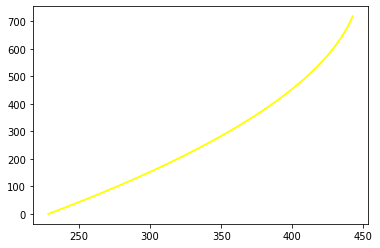

initialized, left_curverad, right_curverad:  544.7122350349894 544.7122350349894


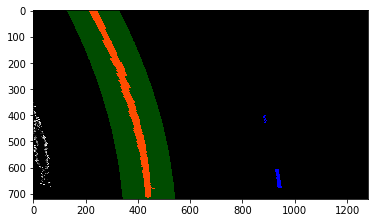

distance[m]:  0.0   0.0
left_curverad, right_curverad:  544.7122350349894 544.7122350349894


t:   4%|█▌                                  | 54/1260 [01:30<32:41,  1.63s/it, now=None]

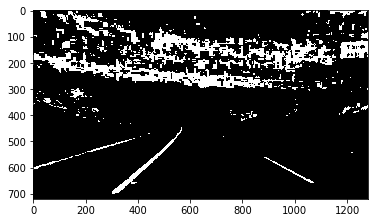

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  952
len(leftx):  20140
len(rightx):  1625


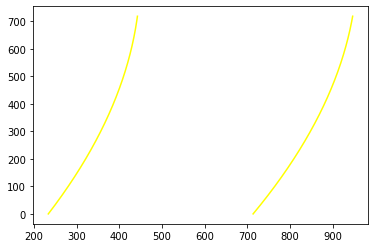

initialized, left_curverad, right_curverad:  579.7404538058777 560.7440398138615


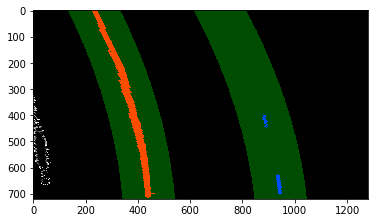

distance[m]:  2.5361886041822124   2.6652792004006507
left_curverad, right_curverad:  579.7404538058777 560.7440398138615


t:   4%|█▌                                  | 55/1260 [01:32<34:45,  1.73s/it, now=None]

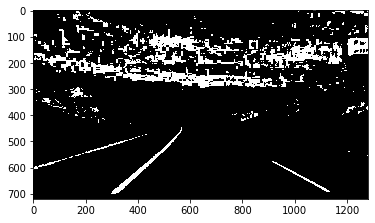

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  953
len(leftx):  21071
len(rightx):  1715


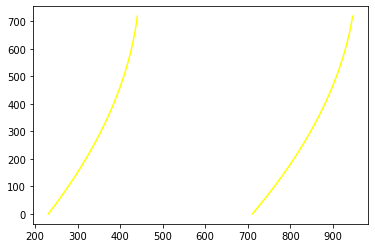

initialized, left_curverad, right_curverad:  567.5121206860529 535.4370983252586


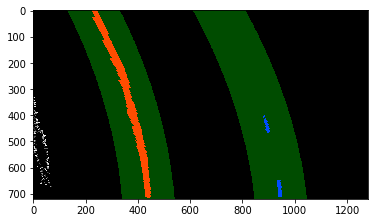

distance[m]:  2.5353372516588784   2.6744057126966845
left_curverad, right_curverad:  567.5121206860529 535.4370983252586


t:   4%|█▌                                  | 56/1260 [01:34<34:48,  1.73s/it, now=None]

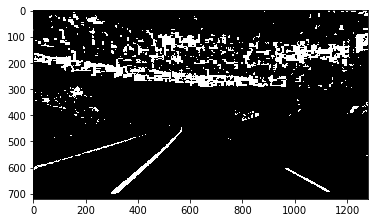

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  952
len(leftx):  21203
len(rightx):  1578


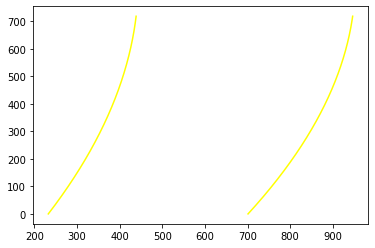

initialized, left_curverad, right_curverad:  565.7533373512389 472.8010761369054


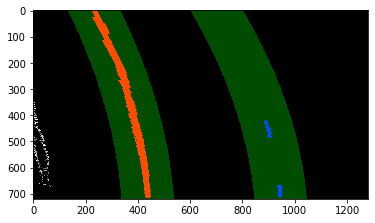

distance[m]:  2.475260630402115   2.683316557090597
left_curverad, right_curverad:  565.7533373512389 472.8010761369054


t:   5%|█▋                                  | 57/1260 [01:35<33:41,  1.68s/it, now=None]

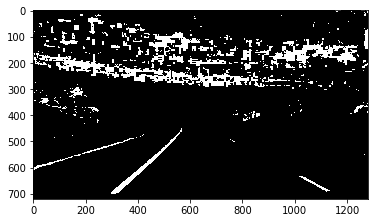

img.shape[0] 720
img.shape[1] 1280
M:  [[-4.02609506e-01 -1.52511132e+00  8.97670084e+02]
 [ 0.00000000e+00 -1.90866729e+00  8.58900280e+02]
 [-0.00000000e+00 -2.38298643e-03  1.00000000e+00]]
max(nonzero[0]:  714
max(nonzero[1]:  952
len(leftx):  21128
len(rightx):  1244
adding 537


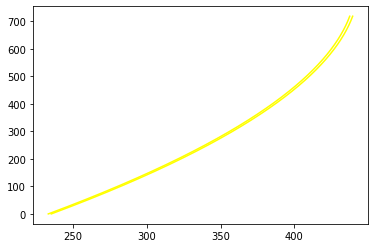

initialized, left_curverad, right_curverad:  549.9185014429297 549.9185014429322


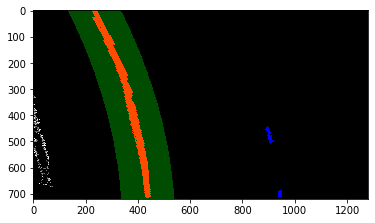

distance[m]:  0.010571428571428572   0.010571428571428572
left_curverad, right_curverad:  549.9185014429297 549.9185014429322


t:   5%|█▋                                  | 58/1260 [01:37<32:48,  1.64s/it, now=None]

In [ ]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(10,5)
clip1 = VideoFileClip("project_video.mp4")
#clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))